In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
train = pd.read_parquet('train.parquet')
val = pd.read_parquet('val.parquet')
test = pd.read_parquet('test.parquet')

In [3]:
target = 'target'

# FIRST

In [4]:
train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
val_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)

params = {
    'objective': 'binary',      
    'boosting_type': 'gbdt',    
    'learning_rate': 0.05,     
    'num_leaves': 31,           
    'max_depth': -1,               
    'verbose': -1,                  
    'random_state': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000
)

Accuracy на тесте: 0.9524
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       188
           1       0.96      0.94      0.95       190

    accuracy                           0.95       378
   macro avg       0.95      0.95      0.95       378
weighted avg       0.95      0.95      0.95       378

ROC-AUC Score на тесте: 0.9905


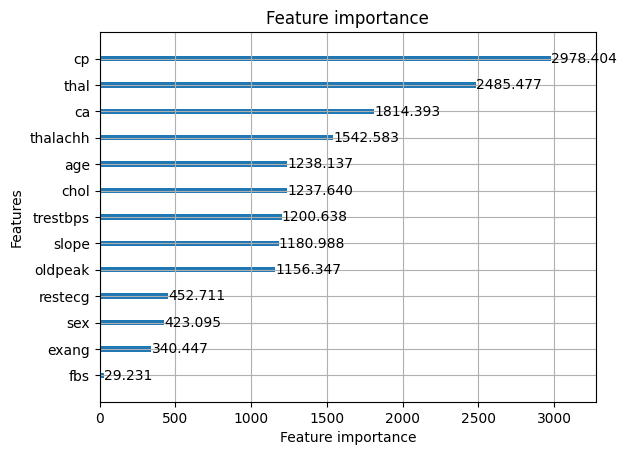

In [5]:
y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int) 

accuracy = accuracy_score(test[target], y_pred)
print(f'Accuracy на тесте: {accuracy:.4f}')
print(classification_report(test[target], y_pred))

lgb.plot_importance(model, max_num_features=50, importance_type='gain')

y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)

roc_auc = roc_auc_score(test[target], y_pred_prob)
print(f'ROC-AUC Score на тесте: {roc_auc:.4f}')

# SECOND

In [6]:
train = train.drop(columns=['fbs', 'exang', 'sex', 'restecg'])
val = val.drop(columns=['fbs', 'exang', 'sex', 'restecg'])
test = test.drop(columns=['fbs', 'exang', 'sex', 'restecg'])

In [7]:
train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
val_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)

params = {
    'objective': 'binary',      
    'boosting_type': 'gbdt',  
    'learning_rate': 0.05,        
    'num_leaves': 31,        
    'max_depth': -1,          
    'verbose': -1,                
    'random_state': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000
)

Accuracy на тесте: 0.9497
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       188
           1       0.96      0.94      0.95       190

    accuracy                           0.95       378
   macro avg       0.95      0.95      0.95       378
weighted avg       0.95      0.95      0.95       378

ROC-AUC Score на тесте: 0.9843


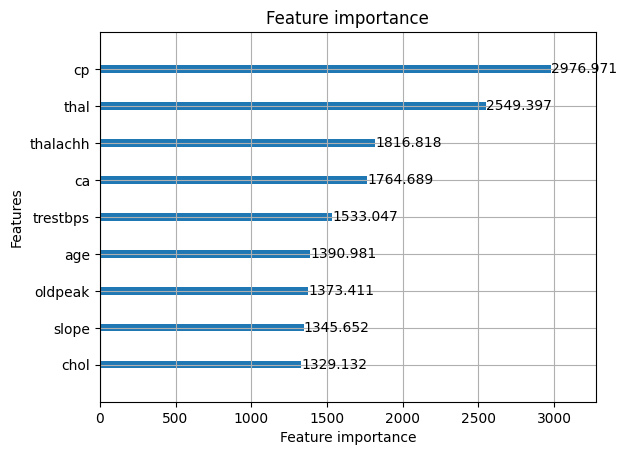

In [8]:
y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)  

accuracy = accuracy_score(test[target], y_pred)
print(f'Accuracy на тесте: {accuracy:.4f}')
print(classification_report(test[target], y_pred))

lgb.plot_importance(model, max_num_features=50, importance_type='gain')

y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)

roc_auc = roc_auc_score(test[target], y_pred_prob)
print(f'ROC-AUC Score на тесте: {roc_auc:.4f}')

In [9]:
roc_auc_train = roc_auc_score(train[target], model.predict(train.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

1.0


In [10]:
roc_auc_train = roc_auc_score(val[target], model.predict(val.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

0.9913581984517945


In [11]:
import lightgbm as lgb
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 100, 3000, step=20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_iterations': trial.suggest_int('num_iterations', 100, 2000),
        'num_boost_round': trial.suggest_int('nub_boost_round', 100, 3000)
    }
    

    train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
    valid_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data]
    )
    

    train_roc_auc = roc_auc_score(train[target], model.predict(train.drop(columns=target), num_iteration=model.best_iteration))

    test_roc_auc = roc_auc_score(test[target], model.predict(test.drop(columns=target), num_iteration=model.best_iteration))
    
    if train_roc_auc - test_roc_auc > 0.3:
        return 0
    else:
        return test_roc_auc
    

study = optuna.create_study(direction='maximize')

study.optimize(
    objective,
    n_trials=200,
    show_progress_bar=True
)

print("Best trial:")
trial = study.best_trial
print(f"  ROC-AUC: {trial.value:.5f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-10 11:42:58,564] A new study created in memory with name: no-name-6e509502-7cb9-4d88-866c-1bb8ec32c71c


  0%|          | 0/200 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1995, num_iterations=592. LightGBM will perform up to 592 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2196, num_iterations=557. LightGBM will perform up to 557 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:42:58,816] Trial 0 finished with value: 0.9572508398656214 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2120, 'learning_rate': 0.27611184366310354, 'min_child_samples': 120, 'min_split_gain': 0.07027508509652225, 'max_depth': 10, 'num_iterations': 592, 'nub_boost_round': 1995}. Best is trial 0 with value: 0.9572508398656214.
[I 2025-04-10 11:42:58,952] Trial 1 finished with value: 0.8766657334826428 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1940, 'learning_rate': 0.19981589123003787, 'min_child_samples': 300, 'min_split_gain': 0.43399825201711606, 'max_depth': 3, 'num_iterations': 557, 'nub_boost_round': 2196}. Best is trial 0 with value: 0.9572508398656214.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=111, num_iterations=873. LightGBM will perform up to 873 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:42:59,323] Trial 2 finished with value: 0.8868840985442329 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 420, 'learning_rate': 0.014925642610564489, 'min_child_samples': 283, 'min_split_gain': 0.15217412916381134, 'max_depth': 9, 'num_iterations': 873, 'nub_boost_round': 111}. Best is trial 0 with value: 0.9572508398656214.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=930, num_iterations=1783. LightGBM will perform up to 1783 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:42:59,778] Trial 3 finished with value: 0.9074468085106383 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1960, 'learning_rate': 0.027654585515452655, 'min_child_samples': 160, 'min_split_gain': 0.9381042428015818, 'max_depth': 10, 'num_iterations': 1783, 'nub_boost_round': 930}. Best is trial 0 with value: 0.9572508398656214.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2602, num_iterations=1509. LightGBM will perform up to 1509 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:00,141] Trial 4 finished with value: 0.9026455767077268 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2700, 'learning_rate': 0.05549895776127391, 'min_child_samples': 199, 'min_split_gain': 0.5260871648018295, 'max_depth': 5, 'num_iterations': 1509, 'nub_boost_round': 2602}. Best is trial 0 with value: 0.9572508398656214.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1772, num_iterations=1515. LightGBM will perform up to 1515 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:04,571] Trial 5 finished with value: 0.9597704367301232 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'learning_rate': 0.017778688585559994, 'min_child_samples': 52, 'min_split_gain': 0.604021828912628, 'max_depth': 6, 'num_iterations': 1515, 'nub_boost_round': 1772}. Best is trial 5 with value: 0.9597704367301232.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1285, num_iterations=1230. LightGBM will perform up to 1230 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:05,198] Trial 6 finished with value: 0.9504479283314669 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2580, 'learning_rate': 0.018424924876353638, 'min_child_samples': 60, 'min_split_gain': 0.47562013528548375, 'max_depth': 7, 'num_iterations': 1230, 'nub_boost_round': 1285}. Best is trial 5 with value: 0.9597704367301232.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1218, num_iterations=1064. LightGBM will perform up to 1064 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1012, num_iterations=155. LightGBM will perform up to 155 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:06,759] Trial 7 finished with value: 0.8915733482642776 and parameters: {'boosting_type': 'dart', 'num_leaves': 980, 'learning_rate': 0.032184079856546394, 'min_child_samples': 257, 'min_split_gain': 0.34740381424729494, 'max_depth': 4, 'num_iterations': 1064, 'nub_boost_round': 1218}. Best is trial 5 with value: 0.9597704367301232.
[I 2025-04-10 11:43:06,900] Trial 8 finished with value: 0.8735862262038074 and parameters: {'boosting_type': 'dart', 'num_leaves': 1360, 'learning_rate': 0.010775229328183868, 'min_child_samples': 170, 'min_split_gain': 0.2628281600882181, 'max_depth': 4, 'num_iterations': 155, 'nub_boost_round': 1012}. Best is trial 5 with value: 0.9597704367301232.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1812, num_iterations=1909. LightGBM will perform up to 1909 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:07,398] Trial 9 finished with value: 0.9126819708846584 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.020929252167191884, 'min_child_samples': 121, 'min_split_gain': 0.9818700722870576, 'max_depth': 3, 'num_iterations': 1909, 'nub_boost_round': 1812}. Best is trial 5 with value: 0.9597704367301232.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2893, num_iterations=1480. LightGBM will perform up to 1480 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:11,682] Trial 10 finished with value: 0.9722564389697649 and parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'learning_rate': 0.07430564978739876, 'min_child_samples': 15, 'min_split_gain': 0.7134322324585185, 'max_depth': 7, 'num_iterations': 1480, 'nub_boost_round': 2893}. Best is trial 10 with value: 0.9722564389697649.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2999, num_iterations=1455. LightGBM will perform up to 1455 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:16,550] Trial 11 finished with value: 0.9816909294512878 and parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'learning_rate': 0.09237439443428999, 'min_child_samples': 3, 'min_split_gain': 0.7300175951684229, 'max_depth': 7, 'num_iterations': 1455, 'nub_boost_round': 2999}. Best is trial 11 with value: 0.9816909294512878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2987, num_iterations=1400. LightGBM will perform up to 1400 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:21,300] Trial 12 finished with value: 0.9818309070548712 and parameters: {'boosting_type': 'dart', 'num_leaves': 580, 'learning_rate': 0.09773215074979234, 'min_child_samples': 4, 'min_split_gain': 0.7353061798087988, 'max_depth': 8, 'num_iterations': 1400, 'nub_boost_round': 2987}. Best is trial 12 with value: 0.9818309070548712.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2922, num_iterations=1249. LightGBM will perform up to 1249 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:25,472] Trial 13 finished with value: 0.9807950727883539 and parameters: {'boosting_type': 'dart', 'num_leaves': 780, 'learning_rate': 0.11128114069186297, 'min_child_samples': 4, 'min_split_gain': 0.7738193593662835, 'max_depth': 8, 'num_iterations': 1249, 'nub_boost_round': 2922}. Best is trial 12 with value: 0.9818309070548712.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2459, num_iterations=1711. LightGBM will perform up to 1711 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:29,030] Trial 14 finished with value: 0.9347984322508398 and parameters: {'boosting_type': 'dart', 'num_leaves': 620, 'learning_rate': 0.12361155294089439, 'min_child_samples': 71, 'min_split_gain': 0.8097538372503306, 'max_depth': 8, 'num_iterations': 1711, 'nub_boost_round': 2459}. Best is trial 12 with value: 0.9818309070548712.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2495, num_iterations=1303. LightGBM will perform up to 1303 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:32,249] Trial 15 finished with value: 0.9629059350503919 and parameters: {'boosting_type': 'dart', 'num_leaves': 500, 'learning_rate': 0.09741153280185628, 'min_child_samples': 34, 'min_split_gain': 0.6591702869356485, 'max_depth': 6, 'num_iterations': 1303, 'nub_boost_round': 2495}. Best is trial 12 with value: 0.9818309070548712.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2829, num_iterations=880. LightGBM will perform up to 880 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:34,099] Trial 16 finished with value: 0.9405935050391937 and parameters: {'boosting_type': 'dart', 'num_leaves': 1660, 'learning_rate': 0.043826763286218526, 'min_child_samples': 90, 'min_split_gain': 0.8734959182768636, 'max_depth': 8, 'num_iterations': 880, 'nub_boost_round': 2829}. Best is trial 12 with value: 0.9818309070548712.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=438, num_iterations=1683. LightGBM will perform up to 1683 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:39,476] Trial 17 finished with value: 0.9844624860022396 and parameters: {'boosting_type': 'dart', 'num_leaves': 340, 'learning_rate': 0.16383681564816008, 'min_child_samples': 1, 'min_split_gain': 0.6194332335491601, 'max_depth': 9, 'num_iterations': 1683, 'nub_boost_round': 438}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=370, num_iterations=2000. LightGBM will perform up to 2000 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:42,791] Trial 18 finished with value: 0.9028975363941769 and parameters: {'boosting_type': 'dart', 'num_leaves': 920, 'learning_rate': 0.1740814299571299, 'min_child_samples': 209, 'min_split_gain': 0.5455101019496149, 'max_depth': 9, 'num_iterations': 2000, 'nub_boost_round': 370}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=650, num_iterations=1764. LightGBM will perform up to 1764 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:46,429] Trial 19 finished with value: 0.936310190369541 and parameters: {'boosting_type': 'dart', 'num_leaves': 1360, 'learning_rate': 0.1606268044549111, 'min_child_samples': 112, 'min_split_gain': 0.3571058344652782, 'max_depth': 9, 'num_iterations': 1764, 'nub_boost_round': 650}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1475, num_iterations=1613. LightGBM will perform up to 1613 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:50,116] Trial 20 finished with value: 0.9650615901455768 and parameters: {'boosting_type': 'dart', 'num_leaves': 400, 'learning_rate': 0.2555095071439032, 'min_child_samples': 36, 'min_split_gain': 0.6010739698690085, 'max_depth': 10, 'num_iterations': 1613, 'nub_boost_round': 1475}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2310, num_iterations=1377. LightGBM will perform up to 1377 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:54,321] Trial 21 finished with value: 0.9772116461366182 and parameters: {'boosting_type': 'dart', 'num_leaves': 260, 'learning_rate': 0.07200235956055245, 'min_child_samples': 7, 'min_split_gain': 0.71908686569187, 'max_depth': 7, 'num_iterations': 1377, 'nub_boost_round': 2310}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2673, num_iterations=1104. LightGBM will perform up to 1104 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:43:57,053] Trial 22 finished with value: 0.9594624860022396 and parameters: {'boosting_type': 'dart', 'num_leaves': 680, 'learning_rate': 0.07824883934239875, 'min_child_samples': 36, 'min_split_gain': 0.8303442293764746, 'max_depth': 8, 'num_iterations': 1104, 'nub_boost_round': 2673}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=624, num_iterations=1632. LightGBM will perform up to 1632 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:00,559] Trial 23 finished with value: 0.9436450167973125 and parameters: {'boosting_type': 'dart', 'num_leaves': 340, 'learning_rate': 0.14222736104126374, 'min_child_samples': 75, 'min_split_gain': 0.6619469223897144, 'max_depth': 9, 'num_iterations': 1632, 'nub_boost_round': 624}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2122, num_iterations=1394. LightGBM will perform up to 1394 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:04,761] Trial 24 finished with value: 0.9734882418812989 and parameters: {'boosting_type': 'dart', 'num_leaves': 820, 'learning_rate': 0.05608298337587293, 'min_child_samples': 4, 'min_split_gain': 0.9110602183453244, 'max_depth': 6, 'num_iterations': 1394, 'nub_boost_round': 2122}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=108, num_iterations=1863. LightGBM will perform up to 1863 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:09,468] Trial 25 finished with value: 0.9624300111982083 and parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'learning_rate': 0.09517713316237585, 'min_child_samples': 32, 'min_split_gain': 0.7608222804149061, 'max_depth': 7, 'num_iterations': 1863, 'nub_boost_round': 108}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2965, num_iterations=928. LightGBM will perform up to 928 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:11,141] Trial 26 finished with value: 0.937010078387458 and parameters: {'boosting_type': 'dart', 'num_leaves': 1080, 'learning_rate': 0.22130891925540475, 'min_child_samples': 99, 'min_split_gain': 0.6332933059826567, 'max_depth': 8, 'num_iterations': 928, 'nub_boost_round': 2965}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2688, num_iterations=1177. LightGBM will perform up to 1177 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:13,883] Trial 27 finished with value: 0.9600223964165733 and parameters: {'boosting_type': 'dart', 'num_leaves': 560, 'learning_rate': 0.1353033976105504, 'min_child_samples': 30, 'min_split_gain': 0.84432305061605, 'max_depth': 9, 'num_iterations': 1177, 'nub_boost_round': 2688}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1889, num_iterations=1602. LightGBM will perform up to 1602 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:17,869] Trial 28 finished with value: 0.9513437849944009 and parameters: {'boosting_type': 'dart', 'num_leaves': 340, 'learning_rate': 0.04298811750974227, 'min_child_samples': 54, 'min_split_gain': 0.7102157512495908, 'max_depth': 5, 'num_iterations': 1602, 'nub_boost_round': 1889}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1602, num_iterations=513. LightGBM will perform up to 513 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:18,555] Trial 29 finished with value: 0.9258398656215006 and parameters: {'boosting_type': 'dart', 'num_leaves': 1240, 'learning_rate': 0.27365133455065005, 'min_child_samples': 125, 'min_split_gain': 0.5561312386776722, 'max_depth': 10, 'num_iterations': 513, 'nub_boost_round': 1602}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2346, num_iterations=1384. LightGBM will perform up to 1384 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:21,262] Trial 30 finished with value: 0.9261198208286674 and parameters: {'boosting_type': 'dart', 'num_leaves': 2920, 'learning_rate': 0.09191740808666485, 'min_child_samples': 138, 'min_split_gain': 0.44158545546659994, 'max_depth': 8, 'num_iterations': 1384, 'nub_boost_round': 2346}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2969, num_iterations=1305. LightGBM will perform up to 1305 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:25,550] Trial 31 finished with value: 0.9823628219484881 and parameters: {'boosting_type': 'dart', 'num_leaves': 760, 'learning_rate': 0.1223335625536343, 'min_child_samples': 1, 'min_split_gain': 0.7626593415286905, 'max_depth': 8, 'num_iterations': 1305, 'nub_boost_round': 2969}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2735, num_iterations=1479. LightGBM will perform up to 1479 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:29,188] Trial 32 finished with value: 0.9655935050391936 and parameters: {'boosting_type': 'dart', 'num_leaves': 620, 'learning_rate': 0.19642440473717748, 'min_child_samples': 24, 'min_split_gain': 0.7484753376109375, 'max_depth': 7, 'num_iterations': 1479, 'nub_boost_round': 2735}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2981, num_iterations=671. LightGBM will perform up to 671 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:31,502] Trial 33 finished with value: 0.9797592385218364 and parameters: {'boosting_type': 'dart', 'num_leaves': 1560, 'learning_rate': 0.11045142209644633, 'min_child_samples': 6, 'min_split_gain': 0.6932654958573815, 'max_depth': 9, 'num_iterations': 671, 'nub_boost_round': 2981}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2115, num_iterations=1692. LightGBM will perform up to 1692 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:31,956] Trial 34 finished with value: 0.9838465845464726 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 460, 'learning_rate': 0.17980137945251973, 'min_child_samples': 21, 'min_split_gain': 0.017838379399161775, 'max_depth': 8, 'num_iterations': 1692, 'nub_boost_round': 2115}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2179, num_iterations=1693. LightGBM will perform up to 1693 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:32,507] Trial 35 finished with value: 0.9770436730123181 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 780, 'learning_rate': 0.15399729232247694, 'min_child_samples': 49, 'min_split_gain': 0.011382902951019624, 'max_depth': 10, 'num_iterations': 1693, 'nub_boost_round': 2179}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2085, num_iterations=1859. LightGBM will perform up to 1859 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:32,897] Trial 36 finished with value: 0.9528555431131018 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 500, 'learning_rate': 0.22395231063632098, 'min_child_samples': 79, 'min_split_gain': 0.15109994582013608, 'max_depth': 9, 'num_iterations': 1859, 'nub_boost_round': 2085}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2471, num_iterations=1544. LightGBM will perform up to 1544 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:33,284] Trial 37 finished with value: 0.978555431131019 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2280, 'learning_rate': 0.2966205944160128, 'min_child_samples': 21, 'min_split_gain': 0.14689796879875364, 'max_depth': 8, 'num_iterations': 1544, 'nub_boost_round': 2471}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1614, num_iterations=1137. LightGBM will perform up to 1137 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:33,609] Trial 38 finished with value: 0.9702407614781635 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1760, 'learning_rate': 0.17997253053144893, 'min_child_samples': 52, 'min_split_gain': 0.24123027795893376, 'max_depth': 9, 'num_iterations': 1137, 'nub_boost_round': 1614}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1133, num_iterations=1281. LightGBM will perform up to 1281 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:33,883] Trial 39 finished with value: 0.8925671892497201 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 280, 'learning_rate': 0.12350882905044493, 'min_child_samples': 246, 'min_split_gain': 0.4845526215151523, 'max_depth': 10, 'num_iterations': 1281, 'nub_boost_round': 1133}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1367, num_iterations=1028. LightGBM will perform up to 1028 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:34,162] Trial 40 finished with value: 0.9097004479283315 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1020, 'learning_rate': 0.06698660558958972, 'min_child_samples': 183, 'min_split_gain': 0.3786940655541347, 'max_depth': 8, 'num_iterations': 1028, 'nub_boost_round': 1367}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2830, num_iterations=1423. LightGBM will perform up to 1423 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:34,510] Trial 41 finished with value: 0.9697648376259799 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'learning_rate': 0.09128930797088346, 'min_child_samples': 17, 'min_split_gain': 0.6000560695760724, 'max_depth': 7, 'num_iterations': 1423, 'nub_boost_round': 2830}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2587, num_iterations=1782. LightGBM will perform up to 1782 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:39,169] Trial 42 finished with value: 0.96984882418813 and parameters: {'boosting_type': 'dart', 'num_leaves': 480, 'learning_rate': 0.15274992114552702, 'min_child_samples': 16, 'min_split_gain': 0.7931312964028401, 'max_depth': 7, 'num_iterations': 1782, 'nub_boost_round': 2587}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=788, num_iterations=1659. LightGBM will perform up to 1659 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:39,567] Trial 43 finished with value: 0.9795632698768197 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 380, 'learning_rate': 0.11346728353657438, 'min_child_samples': 3, 'min_split_gain': 0.8940602316118794, 'max_depth': 6, 'num_iterations': 1659, 'nub_boost_round': 788}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2785, num_iterations=1543. LightGBM will perform up to 1543 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:43,001] Trial 44 finished with value: 0.9603023516237402 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'learning_rate': 0.19400133456002677, 'min_child_samples': 43, 'min_split_gain': 0.567967869552997, 'max_depth': 8, 'num_iterations': 1543, 'nub_boost_round': 2785}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2291, num_iterations=1311. LightGBM will perform up to 1311 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:45,488] Trial 45 finished with value: 0.9402015677491602 and parameters: {'boosting_type': 'dart', 'num_leaves': 700, 'learning_rate': 0.2255372993073848, 'min_child_samples': 61, 'min_split_gain': 0.9947700173428027, 'max_depth': 7, 'num_iterations': 1311, 'nub_boost_round': 2291}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=276, num_iterations=1482. LightGBM will perform up to 1482 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:45,929] Trial 46 finished with value: 0.9771696528555431 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 860, 'learning_rate': 0.06367774831594433, 'min_child_samples': 1, 'min_split_gain': 0.6593791139437836, 'max_depth': 8, 'num_iterations': 1482, 'nub_boost_round': 276}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2567, num_iterations=1968. LightGBM will perform up to 1968 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:51,178] Trial 47 finished with value: 0.9743281075027995 and parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'learning_rate': 0.1319876760500303, 'min_child_samples': 21, 'min_split_gain': 0.26934048358419277, 'max_depth': 6, 'num_iterations': 1968, 'nub_boost_round': 2567}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1996, num_iterations=1722. LightGBM will perform up to 1722 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:54,886] Trial 48 finished with value: 0.9393617021276597 and parameters: {'boosting_type': 'dart', 'num_leaves': 460, 'learning_rate': 0.08205838147824925, 'min_child_samples': 66, 'min_split_gain': 0.856150349761204, 'max_depth': 5, 'num_iterations': 1722, 'nub_boost_round': 1996}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2999, num_iterations=980. LightGBM will perform up to 980 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:57,093] Trial 49 finished with value: 0.9575307950727883 and parameters: {'boosting_type': 'dart', 'num_leaves': 660, 'learning_rate': 0.10285214365456423, 'min_child_samples': 40, 'min_split_gain': 0.748291927583528, 'max_depth': 8, 'num_iterations': 980, 'nub_boost_round': 2999}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1765, num_iterations=1200. LightGBM will perform up to 1200 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:44:57,394] Trial 50 finished with value: 0.9333146696528556 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2180, 'learning_rate': 0.17672688450743762, 'min_child_samples': 88, 'min_split_gain': 0.801149782782026, 'max_depth': 9, 'num_iterations': 1200, 'nub_boost_round': 1765}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2865, num_iterations=1251. LightGBM will perform up to 1251 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:01,095] Trial 51 finished with value: 0.9723404255319148 and parameters: {'boosting_type': 'dart', 'num_leaves': 800, 'learning_rate': 0.1135505080029341, 'min_child_samples': 14, 'min_split_gain': 0.7738832653174958, 'max_depth': 8, 'num_iterations': 1251, 'nub_boost_round': 2865}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2894, num_iterations=1336. LightGBM will perform up to 1336 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:06,157] Trial 52 finished with value: 0.9775195968645016 and parameters: {'boosting_type': 'dart', 'num_leaves': 940, 'learning_rate': 0.04550690933694753, 'min_child_samples': 1, 'min_split_gain': 0.935237209261562, 'max_depth': 8, 'num_iterations': 1336, 'nub_boost_round': 2894}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2372, num_iterations=1575. LightGBM will perform up to 1575 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:10,639] Trial 53 finished with value: 0.96993281075028 and parameters: {'boosting_type': 'dart', 'num_leaves': 560, 'learning_rate': 0.08353874681356495, 'min_child_samples': 27, 'min_split_gain': 0.5207120351435567, 'max_depth': 7, 'num_iterations': 1575, 'nub_boost_round': 2372}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2708, num_iterations=1439. LightGBM will perform up to 1439 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:17,817] Trial 54 finished with value: 0.9784994400895857 and parameters: {'boosting_type': 'dart', 'num_leaves': 1280, 'learning_rate': 0.010280421278539278, 'min_child_samples': 12, 'min_split_gain': 0.6964600683903661, 'max_depth': 7, 'num_iterations': 1439, 'nub_boost_round': 2708}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2842, num_iterations=736. LightGBM will perform up to 736 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:19,379] Trial 55 finished with value: 0.961030235162374 and parameters: {'boosting_type': 'dart', 'num_leaves': 720, 'learning_rate': 0.12468755166088526, 'min_child_samples': 44, 'min_split_gain': 0.6098744161667666, 'max_depth': 9, 'num_iterations': 736, 'nub_boost_round': 2842}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2585, num_iterations=109. LightGBM will perform up to 109 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:19,586] Trial 56 finished with value: 0.968505039193729 and parameters: {'boosting_type': 'dart', 'num_leaves': 400, 'learning_rate': 0.16275960864080882, 'min_child_samples': 25, 'min_split_gain': 0.7340702176474394, 'max_depth': 9, 'num_iterations': 109, 'nub_boost_round': 2585}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2921, num_iterations=1835. LightGBM will perform up to 1835 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:25,313] Trial 57 finished with value: 0.9777995520716685 and parameters: {'boosting_type': 'dart', 'num_leaves': 1120, 'learning_rate': 0.14471580472330936, 'min_child_samples': 11, 'min_split_gain': 0.677327697641924, 'max_depth': 8, 'num_iterations': 1835, 'nub_boost_round': 2921}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1028, num_iterations=1101. LightGBM will perform up to 1101 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:27,990] Trial 58 finished with value: 0.9628779395296753 and parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'learning_rate': 0.10328719113355235, 'min_child_samples': 33, 'min_split_gain': 0.8216679122497921, 'max_depth': 8, 'num_iterations': 1101, 'nub_boost_round': 1028}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2670, num_iterations=1352. LightGBM will perform up to 1352 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:30,145] Trial 59 finished with value: 0.903513437849944 and parameters: {'boosting_type': 'dart', 'num_leaves': 580, 'learning_rate': 0.03133769625343307, 'min_child_samples': 209, 'min_split_gain': 0.6341928136112847, 'max_depth': 7, 'num_iterations': 1352, 'nub_boost_round': 2670}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=510, num_iterations=403. LightGBM will perform up to 403 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:30,531] Trial 60 finished with value: 0.8870940649496081 and parameters: {'boosting_type': 'dart', 'num_leaves': 320, 'learning_rate': 0.05317240323524975, 'min_child_samples': 245, 'min_split_gain': 0.946882583311252, 'max_depth': 8, 'num_iterations': 403, 'nub_boost_round': 510}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2992, num_iterations=267. LightGBM will perform up to 267 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:31,308] Trial 61 finished with value: 0.9780795072788354 and parameters: {'boosting_type': 'dart', 'num_leaves': 1520, 'learning_rate': 0.10672787452343419, 'min_child_samples': 11, 'min_split_gain': 0.7087165997004067, 'max_depth': 9, 'num_iterations': 267, 'nub_boost_round': 2992}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2758, num_iterations=750. LightGBM will perform up to 750 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:33,817] Trial 62 finished with value: 0.9817749160134378 and parameters: {'boosting_type': 'dart', 'num_leaves': 1520, 'learning_rate': 0.11965403656524946, 'min_child_samples': 3, 'min_split_gain': 0.7723956652485221, 'max_depth': 9, 'num_iterations': 750, 'nub_boost_round': 2758}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2792, num_iterations=826. LightGBM will perform up to 826 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:34,996] Trial 63 finished with value: 0.8888017917133259 and parameters: {'boosting_type': 'dart', 'num_leaves': 2340, 'learning_rate': 0.08948932040939198, 'min_child_samples': 292, 'min_split_gain': 0.7798397199581565, 'max_depth': 10, 'num_iterations': 826, 'nub_boost_round': 2792}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2426, num_iterations=1228. LightGBM will perform up to 1228 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:38,143] Trial 64 finished with value: 0.9627659574468086 and parameters: {'boosting_type': 'dart', 'num_leaves': 2000, 'learning_rate': 0.13360202592335724, 'min_child_samples': 26, 'min_split_gain': 0.8803669763979373, 'max_depth': 9, 'num_iterations': 1228, 'nub_boost_round': 2426}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2727, num_iterations=1452. LightGBM will perform up to 1452 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:43,208] Trial 65 finished with value: 0.9798152295632699 and parameters: {'boosting_type': 'dart', 'num_leaves': 900, 'learning_rate': 0.0718217202772351, 'min_child_samples': 3, 'min_split_gain': 0.8320993485579437, 'max_depth': 9, 'num_iterations': 1452, 'nub_boost_round': 2727}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2898, num_iterations=1146. LightGBM will perform up to 1146 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:45,716] Trial 66 finished with value: 0.9597984322508399 and parameters: {'boosting_type': 'dart', 'num_leaves': 440, 'learning_rate': 0.24544527755218662, 'min_child_samples': 34, 'min_split_gain': 0.7411797281638107, 'max_depth': 8, 'num_iterations': 1146, 'nub_boost_round': 2898}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2534, num_iterations=1517. LightGBM will perform up to 1517 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:51,393] Trial 67 finished with value: 0.9821388577827548 and parameters: {'boosting_type': 'dart', 'num_leaves': 760, 'learning_rate': 0.12167580899511043, 'min_child_samples': 16, 'min_split_gain': 0.06316670898129156, 'max_depth': 9, 'num_iterations': 1517, 'nub_boost_round': 2534}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2499, num_iterations=1654. LightGBM will perform up to 1654 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:45:56,559] Trial 68 finished with value: 0.9751959686450168 and parameters: {'boosting_type': 'dart', 'num_leaves': 2520, 'learning_rate': 0.1223241288128007, 'min_child_samples': 59, 'min_split_gain': 0.07988546308611313, 'max_depth': 10, 'num_iterations': 1654, 'nub_boost_round': 2499}. Best is trial 17 with value: 0.9844624860022396.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2237, num_iterations=1743. LightGBM will perform up to 1743 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:00,662] Trial 69 finished with value: 0.9865341545352743 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1760, 'learning_rate': 0.012622454012338157, 'min_child_samples': 19, 'min_split_gain': 0.003645883647717063, 'max_depth': 9, 'num_iterations': 1743, 'nub_boost_round': 2237}. Best is trial 69 with value: 0.9865341545352743.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2185, num_iterations=1749. LightGBM will perform up to 1749 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:04,528] Trial 70 finished with value: 0.9862541993281075 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1860, 'learning_rate': 0.013582121383490443, 'min_child_samples': 19, 'min_split_gain': 0.0044328319910525976, 'max_depth': 10, 'num_iterations': 1749, 'nub_boost_round': 2185}. Best is trial 69 with value: 0.9865341545352743.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2260, num_iterations=1931. LightGBM will perform up to 1931 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:09,231] Trial 71 finished with value: 0.9892217245240762 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1820, 'learning_rate': 0.013240413561800921, 'min_child_samples': 14, 'min_split_gain': 0.0013385439914362154, 'max_depth': 10, 'num_iterations': 1931, 'nub_boost_round': 2260}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2203, num_iterations=1815. LightGBM will perform up to 1815 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:12,956] Trial 72 finished with value: 0.9877099664053751 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1820, 'learning_rate': 0.012006342847422425, 'min_child_samples': 20, 'min_split_gain': 0.009710479188834605, 'max_depth': 10, 'num_iterations': 1815, 'nub_boost_round': 2203}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2219, num_iterations=1953. LightGBM will perform up to 1953 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:16,726] Trial 73 finished with value: 0.9788913773796193 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1840, 'learning_rate': 0.012737582994089433, 'min_child_samples': 43, 'min_split_gain': 0.00025419136555340435, 'max_depth': 10, 'num_iterations': 1953, 'nub_boost_round': 2219}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1999, num_iterations=1823. LightGBM will perform up to 1823 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:18,525] Trial 74 finished with value: 0.9854703247480403 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1920, 'learning_rate': 0.017270288929541786, 'min_child_samples': 22, 'min_split_gain': 0.05054367703122192, 'max_depth': 10, 'num_iterations': 1823, 'nub_boost_round': 1999}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1940, num_iterations=1819. LightGBM will perform up to 1819 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:20,503] Trial 75 finished with value: 0.976511758118701 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2040, 'learning_rate': 0.015998752443769387, 'min_child_samples': 48, 'min_split_gain': 0.040449226687192134, 'max_depth': 10, 'num_iterations': 1819, 'nub_boost_round': 1940}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2099, num_iterations=1742. LightGBM will perform up to 1742 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:22,400] Trial 76 finished with value: 0.9828107502799552 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1880, 'learning_rate': 0.012750795477873025, 'min_child_samples': 28, 'min_split_gain': 0.11250686923382654, 'max_depth': 10, 'num_iterations': 1742, 'nub_boost_round': 2099}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2053, num_iterations=1933. LightGBM will perform up to 1933 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:24,335] Trial 77 finished with value: 0.9826147816349384 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1880, 'learning_rate': 0.011983133361677797, 'min_child_samples': 22, 'min_split_gain': 0.11440283235819956, 'max_depth': 10, 'num_iterations': 1933, 'nub_boost_round': 2053}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1802, num_iterations=1898. LightGBM will perform up to 1898 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:25,551] Trial 78 finished with value: 0.9687010078387458 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1700, 'learning_rate': 0.021280334964458355, 'min_child_samples': 55, 'min_split_gain': 0.09957179715786271, 'max_depth': 10, 'num_iterations': 1898, 'nub_boost_round': 1802}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2183, num_iterations=1704. LightGBM will perform up to 1704 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:28,136] Trial 79 finished with value: 0.9793393057110862 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2100, 'learning_rate': 0.013818141179041952, 'min_child_samples': 38, 'min_split_gain': 0.03254006830494671, 'max_depth': 10, 'num_iterations': 1704, 'nub_boost_round': 2183}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2272, num_iterations=1755. LightGBM will perform up to 1755 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:29,242] Trial 80 finished with value: 0.975363941769317 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1920, 'learning_rate': 0.019375736644940737, 'min_child_samples': 29, 'min_split_gain': 0.19250818432246963, 'max_depth': 10, 'num_iterations': 1755, 'nub_boost_round': 2272}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=2063, num_iterations=1800. LightGBM will perform up to 1800 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:31,290] Trial 81 finished with value: 0.9840145576707726 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1860, 'learning_rate': 0.011626132012972768, 'min_child_samples': 21, 'min_split_gain': 0.11410898618442039, 'max_depth': 10, 'num_iterations': 1800, 'nub_boost_round': 2063}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1916, num_iterations=1807. LightGBM will perform up to 1807 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:34,096] Trial 82 finished with value: 0.9845464725643898 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1620, 'learning_rate': 0.0115353812620593, 'min_child_samples': 18, 'min_split_gain': 0.03529210080344522, 'max_depth': 10, 'num_iterations': 1807, 'nub_boost_round': 1916}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1896, num_iterations=1879. LightGBM will perform up to 1879 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:36,320] Trial 83 finished with value: 0.9858902575587906 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1760, 'learning_rate': 0.01562506873638207, 'min_child_samples': 18, 'min_split_gain': 0.0323636019048641, 'max_depth': 10, 'num_iterations': 1879, 'nub_boost_round': 1896}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1864, num_iterations=1899. LightGBM will perform up to 1899 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:38,490] Trial 84 finished with value: 0.9874300111982084 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1640, 'learning_rate': 0.0154720686832703, 'min_child_samples': 11, 'min_split_gain': 0.05321840510894546, 'max_depth': 10, 'num_iterations': 1899, 'nub_boost_round': 1864}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1712, num_iterations=1992. LightGBM will perform up to 1992 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:39,824] Trial 85 finished with value: 0.9400055991041433 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1620, 'learning_rate': 0.015543848906499312, 'min_child_samples': 152, 'min_split_gain': 0.055172596635180024, 'max_depth': 10, 'num_iterations': 1992, 'nub_boost_round': 1712}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1880, num_iterations=1881. LightGBM will perform up to 1881 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:41,223] Trial 86 finished with value: 0.9858902575587905 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1760, 'learning_rate': 0.023298443236549525, 'min_child_samples': 14, 'min_split_gain': 0.08546704338542468, 'max_depth': 10, 'num_iterations': 1881, 'nub_boost_round': 1880}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1886, num_iterations=1899. LightGBM will perform up to 1899 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:42,631] Trial 87 finished with value: 0.9869260918253081 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1440, 'learning_rate': 0.023886792082420897, 'min_child_samples': 11, 'min_split_gain': 0.08204961255133372, 'max_depth': 10, 'num_iterations': 1899, 'nub_boost_round': 1886}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1678, num_iterations=1892. LightGBM will perform up to 1892 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:43,898] Trial 88 finished with value: 0.98488241881299 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1760, 'learning_rate': 0.023459657478832496, 'min_child_samples': 9, 'min_split_gain': 0.19170109344487776, 'max_depth': 10, 'num_iterations': 1892, 'nub_boost_round': 1678}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1856, num_iterations=1876. LightGBM will perform up to 1876 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:45,037] Trial 89 finished with value: 0.9493561030235164 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1440, 'learning_rate': 0.017485023854109567, 'min_child_samples': 35, 'min_split_gain': 0.08346103319220924, 'max_depth': 3, 'num_iterations': 1876, 'nub_boost_round': 1856}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1940, num_iterations=1953. LightGBM will perform up to 1953 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:46,329] Trial 90 finished with value: 0.9630459126539754 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1740, 'learning_rate': 0.014147645446753421, 'min_child_samples': 68, 'min_split_gain': 0.134694243133134, 'max_depth': 10, 'num_iterations': 1953, 'nub_boost_round': 1940}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1702, num_iterations=1908. LightGBM will perform up to 1908 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:47,459] Trial 91 finished with value: 0.9840985442329228 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1780, 'learning_rate': 0.0265410499705993, 'min_child_samples': 11, 'min_split_gain': 0.17729955578851458, 'max_depth': 10, 'num_iterations': 1908, 'nub_boost_round': 1702}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1452, num_iterations=1857. LightGBM will perform up to 1857 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:49,460] Trial 92 finished with value: 0.9878219484882418 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1420, 'learning_rate': 0.023572774528327296, 'min_child_samples': 12, 'min_split_gain': 0.01340026759910173, 'max_depth': 10, 'num_iterations': 1857, 'nub_boost_round': 1452}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1472, num_iterations=1841. LightGBM will perform up to 1841 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:51,763] Trial 93 finished with value: 0.9876259798432251 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1440, 'learning_rate': 0.017327130880826422, 'min_child_samples': 16, 'min_split_gain': 0.020076807929288065, 'max_depth': 10, 'num_iterations': 1841, 'nub_boost_round': 1472}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1379, num_iterations=1847. LightGBM will perform up to 1847 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:54,030] Trial 94 finished with value: 0.9889977603583426 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1400, 'learning_rate': 0.01951016880653777, 'min_child_samples': 10, 'min_split_gain': 0.016032038688603284, 'max_depth': 10, 'num_iterations': 1847, 'nub_boost_round': 1379}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1395, num_iterations=1770. LightGBM will perform up to 1770 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:46:56,455] Trial 95 finished with value: 0.9885498320268756 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1340, 'learning_rate': 0.019353892641244954, 'min_child_samples': 9, 'min_split_gain': 0.013196832945578045, 'max_depth': 10, 'num_iterations': 1770, 'nub_boost_round': 1395}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1409, num_iterations=1769. LightGBM will perform up to 1769 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:00,663] Trial 96 finished with value: 0.9852183650615902 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1400, 'learning_rate': 0.013958181748205086, 'min_child_samples': 30, 'min_split_gain': 0.00316414789808429, 'max_depth': 10, 'num_iterations': 1769, 'nub_boost_round': 1409}. Best is trial 71 with value: 0.9892217245240762.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1260, num_iterations=1997. LightGBM will perform up to 1997 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:02,885] Trial 97 finished with value: 0.9897536394176931 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1280, 'learning_rate': 0.019187326045205143, 'min_child_samples': 8, 'min_split_gain': 0.022496045897021418, 'max_depth': 10, 'num_iterations': 1997, 'nub_boost_round': 1260}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1270, num_iterations=1995. LightGBM will perform up to 1995 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:04,693] Trial 98 finished with value: 0.988073908174692 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1460, 'learning_rate': 0.01961048805475285, 'min_child_samples': 8, 'min_split_gain': 0.06519446789507079, 'max_depth': 10, 'num_iterations': 1995, 'nub_boost_round': 1270}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1502, num_iterations=1997. LightGBM will perform up to 1997 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:06,471] Trial 99 finished with value: 0.9887178051511758 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1240, 'learning_rate': 0.01997659914378016, 'min_child_samples': 8, 'min_split_gain': 0.060695500798712, 'max_depth': 10, 'num_iterations': 1997, 'nub_boost_round': 1502}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1257, num_iterations=1979. LightGBM will perform up to 1979 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:08,334] Trial 100 finished with value: 0.9886058230683091 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.01971400876564338, 'min_child_samples': 9, 'min_split_gain': 0.02598452061359424, 'max_depth': 10, 'num_iterations': 1979, 'nub_boost_round': 1257}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1255, num_iterations=1969. LightGBM will perform up to 1969 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:10,209] Trial 101 finished with value: 0.9883538633818589 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1240, 'learning_rate': 0.019246170164329498, 'min_child_samples': 6, 'min_split_gain': 0.06482697625484676, 'max_depth': 10, 'num_iterations': 1969, 'nub_boost_round': 1255}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1261, num_iterations=1991. LightGBM will perform up to 1991 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:12,353] Trial 102 finished with value: 0.9891657334826427 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.01940182384878344, 'min_child_samples': 8, 'min_split_gain': 0.02588465423244913, 'max_depth': 10, 'num_iterations': 1991, 'nub_boost_round': 1261}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1200, num_iterations=1998. LightGBM will perform up to 1998 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:14,112] Trial 103 finished with value: 0.9878779395296753 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.019840081392325334, 'min_child_samples': 8, 'min_split_gain': 0.07132151638873117, 'max_depth': 10, 'num_iterations': 1998, 'nub_boost_round': 1200}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1240, num_iterations=1936. LightGBM will perform up to 1936 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:15,875] Trial 104 finished with value: 0.9879339305711086 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.020308224608213587, 'min_child_samples': 6, 'min_split_gain': 0.07119639942880045, 'max_depth': 10, 'num_iterations': 1936, 'nub_boost_round': 1240}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1250, num_iterations=1999. LightGBM will perform up to 1999 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:17,702] Trial 105 finished with value: 0.9868141097424412 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1240, 'learning_rate': 0.019568452660875944, 'min_child_samples': 7, 'min_split_gain': 0.06634468212068458, 'max_depth': 10, 'num_iterations': 1999, 'nub_boost_round': 1250}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1178, num_iterations=1945. LightGBM will perform up to 1945 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:19,227] Trial 106 finished with value: 0.9867581187010079 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.021083481629340223, 'min_child_samples': 6, 'min_split_gain': 0.13453226837529095, 'max_depth': 10, 'num_iterations': 1945, 'nub_boost_round': 1178}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1318, num_iterations=1975. LightGBM will perform up to 1975 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:20,604] Trial 107 finished with value: 0.9809490481522957 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1300, 'learning_rate': 0.02753347973376242, 'min_child_samples': 1, 'min_split_gain': 0.0991809450972248, 'max_depth': 10, 'num_iterations': 1975, 'nub_boost_round': 1318}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1065, num_iterations=1934. LightGBM will perform up to 1934 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:21,591] Trial 108 finished with value: 0.9701567749160134 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1040, 'learning_rate': 0.030351880635865924, 'min_child_samples': 8, 'min_split_gain': 0.061714751939673664, 'max_depth': 4, 'num_iterations': 1934, 'nub_boost_round': 1065}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=906, num_iterations=1999. LightGBM will perform up to 1999 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:23,376] Trial 109 finished with value: 0.9762038073908176 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.019793527180061492, 'min_child_samples': 37, 'min_split_gain': 0.03189171416106234, 'max_depth': 9, 'num_iterations': 1999, 'nub_boost_round': 906}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1327, num_iterations=1930. LightGBM will perform up to 1930 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:24,213] Trial 110 finished with value: 0.9417973124300112 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1340, 'learning_rate': 0.025723639590335527, 'min_child_samples': 111, 'min_split_gain': 0.157275720695015, 'max_depth': 10, 'num_iterations': 1930, 'nub_boost_round': 1327}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1516, num_iterations=1857. LightGBM will perform up to 1857 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:25,453] Trial 111 finished with value: 0.9839025755879058 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.035258027367695975, 'min_child_samples': 26, 'min_split_gain': 0.02598135720390774, 'max_depth': 10, 'num_iterations': 1857, 'nub_boost_round': 1516}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1410, num_iterations=1967. LightGBM will perform up to 1967 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:27,271] Trial 112 finished with value: 0.9887178051511758 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1080, 'learning_rate': 0.02147489834942065, 'min_child_samples': 6, 'min_split_gain': 0.05107503584787704, 'max_depth': 10, 'num_iterations': 1967, 'nub_boost_round': 1410}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1118, num_iterations=1976. LightGBM will perform up to 1976 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:29,411] Trial 113 finished with value: 0.9879899216125421 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.018412200330998815, 'min_child_samples': 5, 'min_split_gain': 0.04787209130088924, 'max_depth': 10, 'num_iterations': 1976, 'nub_boost_round': 1118}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1115, num_iterations=1963. LightGBM will perform up to 1963 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:30,566] Trial 114 finished with value: 0.9210526315789473 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.018184886848837352, 'min_child_samples': 177, 'min_split_gain': 0.10254874684902221, 'max_depth': 10, 'num_iterations': 1963, 'nub_boost_round': 1115}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1575, num_iterations=1921. LightGBM will perform up to 1921 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:32,032] Trial 115 finished with value: 0.9849384098544234 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1000, 'learning_rate': 0.021932918684273967, 'min_child_samples': 2, 'min_split_gain': 0.05203767762798596, 'max_depth': 9, 'num_iterations': 1921, 'nub_boost_round': 1575}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1263, num_iterations=1950. LightGBM will perform up to 1950 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:34,122] Trial 116 finished with value: 0.9820688689809629 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1320, 'learning_rate': 0.018900621501788933, 'min_child_samples': 1, 'min_split_gain': 0.04220828277392859, 'max_depth': 10, 'num_iterations': 1950, 'nub_boost_round': 1263}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1371, num_iterations=1968. LightGBM will perform up to 1968 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:35,595] Trial 117 finished with value: 0.9795632698768197 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1080, 'learning_rate': 0.0161974436164848, 'min_child_samples': 30, 'min_split_gain': 0.12997936728555065, 'max_depth': 10, 'num_iterations': 1968, 'nub_boost_round': 1371}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=925, num_iterations=1909. LightGBM will perform up to 1909 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:37,087] Trial 118 finished with value: 0.985330347144457 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.02520189762806522, 'min_child_samples': 7, 'min_split_gain': 0.08883166068197176, 'max_depth': 10, 'num_iterations': 1909, 'nub_boost_round': 925}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1152, num_iterations=1848. LightGBM will perform up to 1848 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:38,553] Trial 119 finished with value: 0.9837625979843226 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1540, 'learning_rate': 0.022182764719471997, 'min_child_samples': 25, 'min_split_gain': 0.06879702717315184, 'max_depth': 10, 'num_iterations': 1848, 'nub_boost_round': 1152}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=992, num_iterations=1792. LightGBM will perform up to 1792 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:39,705] Trial 120 finished with value: 0.9723124300111983 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1380, 'learning_rate': 0.016562420433182564, 'min_child_samples': 43, 'min_split_gain': 0.23699460385036686, 'max_depth': 9, 'num_iterations': 1792, 'nub_boost_round': 992}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1219, num_iterations=1989. LightGBM will perform up to 1989 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:41,545] Trial 121 finished with value: 0.9878499440089586 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1240, 'learning_rate': 0.020248933452162228, 'min_child_samples': 8, 'min_split_gain': 0.06747514730408338, 'max_depth': 10, 'num_iterations': 1989, 'nub_boost_round': 1219}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1385, num_iterations=1991. LightGBM will perform up to 1991 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:43,963] Trial 122 finished with value: 0.9872620380739082 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1480, 'learning_rate': 0.01830007791893416, 'min_child_samples': 16, 'min_split_gain': 0.02165983907853096, 'max_depth': 10, 'num_iterations': 1991, 'nub_boost_round': 1385}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1298, num_iterations=1929. LightGBM will perform up to 1929 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:45,799] Trial 123 finished with value: 0.9890817469204928 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1260, 'learning_rate': 0.020304500795826776, 'min_child_samples': 14, 'min_split_gain': 0.04075349579352451, 'max_depth': 10, 'num_iterations': 1929, 'nub_boost_round': 1298}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1300, num_iterations=1929. LightGBM will perform up to 1929 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:47,198] Trial 124 finished with value: 0.9881298992161255 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1320, 'learning_rate': 0.028592489596518354, 'min_child_samples': 14, 'min_split_gain': 0.04488601961847566, 'max_depth': 10, 'num_iterations': 1929, 'nub_boost_round': 1300}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1315, num_iterations=1927. LightGBM will perform up to 1927 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:48,585] Trial 125 finished with value: 0.9853863381858903 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1300, 'learning_rate': 0.029411683396869632, 'min_child_samples': 15, 'min_split_gain': 0.037946270095515974, 'max_depth': 10, 'num_iterations': 1927, 'nub_boost_round': 1315}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1088, num_iterations=1874. LightGBM will perform up to 1874 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:50,639] Trial 126 finished with value: 0.9858062709966405 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.03539854676657304, 'min_child_samples': 25, 'min_split_gain': 0.0012582312958374017, 'max_depth': 10, 'num_iterations': 1874, 'nub_boost_round': 1088}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1425, num_iterations=1834. LightGBM will perform up to 1834 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:51,896] Trial 127 finished with value: 0.9852183650615902 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 960, 'learning_rate': 0.01839510746638783, 'min_child_samples': 14, 'min_split_gain': 0.1178833232155479, 'max_depth': 9, 'num_iterations': 1834, 'nub_boost_round': 1425}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1495, num_iterations=1950. LightGBM will perform up to 1950 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:54,059] Trial 128 finished with value: 0.9866741321388579 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.01469682210489032, 'min_child_samples': 22, 'min_split_gain': 0.048072799306213485, 'max_depth': 10, 'num_iterations': 1950, 'nub_boost_round': 1495}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1319, num_iterations=1906. LightGBM will perform up to 1906 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:55,755] Trial 129 finished with value: 0.9820828667413214 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1080, 'learning_rate': 0.022312087995997078, 'min_child_samples': 32, 'min_split_gain': 0.02805191288138304, 'max_depth': 10, 'num_iterations': 1906, 'nub_boost_round': 1319}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=996, num_iterations=1787. LightGBM will perform up to 1787 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:57,478] Trial 130 finished with value: 0.9875979843225084 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1300, 'learning_rate': 0.01747729473857956, 'min_child_samples': 12, 'min_split_gain': 0.08601565633775751, 'max_depth': 10, 'num_iterations': 1787, 'nub_boost_round': 996}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1233, num_iterations=1948. LightGBM will perform up to 1948 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:47:59,287] Trial 131 finished with value: 0.9870380739081747 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.020482511282170174, 'min_child_samples': 6, 'min_split_gain': 0.05190447943647823, 'max_depth': 10, 'num_iterations': 1948, 'nub_boost_round': 1233}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1526, num_iterations=1924. LightGBM will perform up to 1924 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:01,117] Trial 132 finished with value: 0.9821808510638297 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1040, 'learning_rate': 0.02535715042151801, 'min_child_samples': 1, 'min_split_gain': 0.02408330274491856, 'max_depth': 10, 'num_iterations': 1924, 'nub_boost_round': 1526}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1291, num_iterations=1867. LightGBM will perform up to 1867 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:02,636] Trial 133 finished with value: 0.98496640537514 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1480, 'learning_rate': 0.021271453924109694, 'min_child_samples': 18, 'min_split_gain': 0.07262863517904947, 'max_depth': 10, 'num_iterations': 1867, 'nub_boost_round': 1291}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1159, num_iterations=1999. LightGBM will perform up to 1999 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:04,594] Trial 134 finished with value: 0.9862262038073908 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1280, 'learning_rate': 0.016469017662232514, 'min_child_samples': 7, 'min_split_gain': 0.10021630511977855, 'max_depth': 10, 'num_iterations': 1999, 'nub_boost_round': 1159}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1631, num_iterations=1961. LightGBM will perform up to 1961 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:06,270] Trial 135 finished with value: 0.9819148936170212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.018391358508393, 'min_child_samples': 24, 'min_split_gain': 0.04770149102965408, 'max_depth': 10, 'num_iterations': 1961, 'nub_boost_round': 1631}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1364, num_iterations=1896. LightGBM will perform up to 1896 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:07,718] Trial 136 finished with value: 0.9557950727883537 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1580, 'learning_rate': 0.014812146301336801, 'min_child_samples': 131, 'min_split_gain': 0.015698506529617517, 'max_depth': 10, 'num_iterations': 1896, 'nub_boost_round': 1364}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1429, num_iterations=1847. LightGBM will perform up to 1847 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:08,288] Trial 137 finished with value: 0.8906075027995521 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.02379853849600373, 'min_child_samples': 276, 'min_split_gain': 0.4046082341314373, 'max_depth': 10, 'num_iterations': 1847, 'nub_boost_round': 1429}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1263, num_iterations=1963. LightGBM will perform up to 1963 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:09,657] Trial 138 finished with value: 0.986394176931691 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 860, 'learning_rate': 0.019337342493322866, 'min_child_samples': 13, 'min_split_gain': 0.06645949890438799, 'max_depth': 9, 'num_iterations': 1963, 'nub_boost_round': 1263}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1203, num_iterations=1921. LightGBM will perform up to 1921 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:11,139] Trial 139 finished with value: 0.9805291153415453 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1260, 'learning_rate': 0.02171999426768638, 'min_child_samples': 1, 'min_split_gain': 0.1490385771398097, 'max_depth': 10, 'num_iterations': 1921, 'nub_boost_round': 1203}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1552, num_iterations=1827. LightGBM will perform up to 1827 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:12,026] Trial 140 finished with value: 0.9104843225083986 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.017235356525816536, 'min_child_samples': 225, 'min_split_gain': 0.03673191687636315, 'max_depth': 10, 'num_iterations': 1827, 'nub_boost_round': 1552}. Best is trial 97 with value: 0.9897536394176931.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1187, num_iterations=1994. LightGBM will perform up to 1994 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:16,107] Trial 141 finished with value: 0.9908454647256439 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1200, 'learning_rate': 0.02042651720787233, 'min_child_samples': 9, 'min_split_gain': 0.0002939719900524884, 'max_depth': 10, 'num_iterations': 1994, 'nub_boost_round': 1187}. Best is trial 141 with value: 0.9908454647256439.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1120, num_iterations=1999. LightGBM will perform up to 1999 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:17,189] Trial 142 finished with value: 0.9762877939529675 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1200, 'learning_rate': 0.02090865490883608, 'min_child_samples': 18, 'min_split_gain': 0.3081236055417468, 'max_depth': 10, 'num_iterations': 1999, 'nub_boost_round': 1120}. Best is trial 141 with value: 0.9908454647256439.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1371, num_iterations=1956. LightGBM will perform up to 1956 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:19,327] Trial 143 finished with value: 0.9913213885778275 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.02868489348038071, 'min_child_samples': 8, 'min_split_gain': 0.0046041442639857474, 'max_depth': 10, 'num_iterations': 1956, 'nub_boost_round': 1371}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1351, num_iterations=1882. LightGBM will perform up to 1882 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:21,540] Trial 144 finished with value: 0.9878779395296753 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.027775405873565, 'min_child_samples': 11, 'min_split_gain': 0.004157351474162383, 'max_depth': 10, 'num_iterations': 1882, 'nub_boost_round': 1351}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1048, num_iterations=1963. LightGBM will perform up to 1963 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:23,296] Trial 145 finished with value: 0.9874580067189248 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1480, 'learning_rate': 0.040299423811379534, 'min_child_samples': 21, 'min_split_gain': 0.0018753222447697865, 'max_depth': 10, 'num_iterations': 1963, 'nub_boost_round': 1048}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1417, num_iterations=1917. LightGBM will perform up to 1917 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:24,497] Trial 146 finished with value: 0.9835666293393058 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1020, 'learning_rate': 0.033169038552736514, 'min_child_samples': 30, 'min_split_gain': 0.02145101539669436, 'max_depth': 10, 'num_iterations': 1917, 'nub_boost_round': 1417}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1474, num_iterations=1968. LightGBM will perform up to 1968 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:25,712] Trial 147 finished with value: 0.9666573348264277 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1400, 'learning_rate': 0.02285265007127984, 'min_child_samples': 14, 'min_split_gain': 0.04472720231501917, 'max_depth': 4, 'num_iterations': 1968, 'nub_boost_round': 1474}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1290, num_iterations=1866. LightGBM will perform up to 1866 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:27,489] Trial 148 finished with value: 0.9893337066069429 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1280, 'learning_rate': 0.024718697252806458, 'min_child_samples': 9, 'min_split_gain': 0.02468625447849398, 'max_depth': 10, 'num_iterations': 1866, 'nub_boost_round': 1290}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1312, num_iterations=1872. LightGBM will perform up to 1872 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:29,198] Trial 149 finished with value: 0.9791153415453528 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1320, 'learning_rate': 0.025173191635467954, 'min_child_samples': 35, 'min_split_gain': 0.021898836151664176, 'max_depth': 10, 'num_iterations': 1872, 'nub_boost_round': 1312}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1277, num_iterations=1821. LightGBM will perform up to 1821 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:30,269] Trial 150 finished with value: 0.9836226203807391 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1260, 'learning_rate': 0.028134200161164104, 'min_child_samples': 25, 'min_split_gain': 0.08896120745814179, 'max_depth': 10, 'num_iterations': 1821, 'nub_boost_round': 1277}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1153, num_iterations=1923. LightGBM will perform up to 1923 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:32,237] Trial 151 finished with value: 0.9879059350503919 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1080, 'learning_rate': 0.019305482497606854, 'min_child_samples': 6, 'min_split_gain': 0.045163162996219336, 'max_depth': 10, 'num_iterations': 1923, 'nub_boost_round': 1153}. Best is trial 143 with value: 0.9913213885778275.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1191, num_iterations=1997. LightGBM will perform up to 1997 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:35,588] Trial 152 finished with value: 0.9916293393057112 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.024877454938289106, 'min_child_samples': 10, 'min_split_gain': 0.0003135820089807881, 'max_depth': 10, 'num_iterations': 1997, 'nub_boost_round': 1191}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1386, num_iterations=1998. LightGBM will perform up to 1998 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:38,668] Trial 153 finished with value: 0.9879339305711087 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1320, 'learning_rate': 0.024104929511338132, 'min_child_samples': 17, 'min_split_gain': 0.0007391564867783894, 'max_depth': 10, 'num_iterations': 1998, 'nub_boost_round': 1386}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1195, num_iterations=1883. LightGBM will perform up to 1883 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:40,395] Trial 154 finished with value: 0.9820128779395296 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1420, 'learning_rate': 0.02699770651600663, 'min_child_samples': 1, 'min_split_gain': 0.027458021280671936, 'max_depth': 10, 'num_iterations': 1883, 'nub_boost_round': 1195}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1285, num_iterations=1936. LightGBM will perform up to 1936 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:42,317] Trial 155 finished with value: 0.9885498320268757 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.02284752155041455, 'min_child_samples': 10, 'min_split_gain': 0.02028245493746105, 'max_depth': 10, 'num_iterations': 1936, 'nub_boost_round': 1285}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1352, num_iterations=1946. LightGBM will perform up to 1946 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:44,228] Trial 156 finished with value: 0.9887737961926092 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.022395749034489435, 'min_child_samples': 12, 'min_split_gain': 0.02327443806040582, 'max_depth': 10, 'num_iterations': 1946, 'nub_boost_round': 1352}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1451, num_iterations=1777. LightGBM will perform up to 1777 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:46,231] Trial 157 finished with value: 0.9896136618141097 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.0218908371066334, 'min_child_samples': 10, 'min_split_gain': 0.020523015705781657, 'max_depth': 10, 'num_iterations': 1777, 'nub_boost_round': 1451}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1590, num_iterations=1715. LightGBM will perform up to 1715 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:47,797] Trial 158 finished with value: 0.9854423292273236 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 960, 'learning_rate': 0.02267760350619158, 'min_child_samples': 21, 'min_split_gain': 0.021574731226455937, 'max_depth': 10, 'num_iterations': 1715, 'nub_boost_round': 1590}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1474, num_iterations=1784. LightGBM will perform up to 1784 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:50,511] Trial 159 finished with value: 0.9877939529675253 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.025468091370628262, 'min_child_samples': 11, 'min_split_gain': 0.0011091019036791189, 'max_depth': 9, 'num_iterations': 1784, 'nub_boost_round': 1474}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1376, num_iterations=1843. LightGBM will perform up to 1843 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:52,438] Trial 160 finished with value: 0.9827267637178052 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1120, 'learning_rate': 0.022117999999899936, 'min_child_samples': 29, 'min_split_gain': 0.0217944691050605, 'max_depth': 10, 'num_iterations': 1843, 'nub_boost_round': 1376}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1428, num_iterations=1955. LightGBM will perform up to 1955 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:55,865] Trial 161 finished with value: 0.9906494960806271 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.021010652836515376, 'min_child_samples': 10, 'min_split_gain': 0.0008748549033700467, 'max_depth': 10, 'num_iterations': 1955, 'nub_boost_round': 1428}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1445, num_iterations=1903. LightGBM will perform up to 1903 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:57,715] Trial 162 finished with value: 0.9886058230683091 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.024251161672707314, 'min_child_samples': 11, 'min_split_gain': 0.02114749758170799, 'max_depth': 10, 'num_iterations': 1903, 'nub_boost_round': 1445}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1531, num_iterations=1900. LightGBM will perform up to 1900 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:48:59,510] Trial 163 finished with value: 0.9856103023516238 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1060, 'learning_rate': 0.021064455732999535, 'min_child_samples': 16, 'min_split_gain': 0.034069352856792016, 'max_depth': 10, 'num_iterations': 1900, 'nub_boost_round': 1531}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1632, num_iterations=1945. LightGBM will perform up to 1945 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:02,775] Trial 164 finished with value: 0.9854703247480403 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.024122404426299534, 'min_child_samples': 1, 'min_split_gain': 0.0002030208949872288, 'max_depth': 10, 'num_iterations': 1945, 'nub_boost_round': 1632}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1459, num_iterations=1878. LightGBM will perform up to 1878 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:04,057] Trial 165 finished with value: 0.9868421052631579 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1000, 'learning_rate': 0.0265177649676409, 'min_child_samples': 20, 'min_split_gain': 0.032629414507959864, 'max_depth': 10, 'num_iterations': 1878, 'nub_boost_round': 1459}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1425, num_iterations=1942. LightGBM will perform up to 1942 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:05,563] Trial 166 finished with value: 0.987374020156775 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1200, 'learning_rate': 0.024556781180388766, 'min_child_samples': 11, 'min_split_gain': 0.05847028747913448, 'max_depth': 10, 'num_iterations': 1942, 'nub_boost_round': 1425}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1350, num_iterations=1906. LightGBM will perform up to 1906 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:07,215] Trial 167 finished with value: 0.9842665173572229 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 900, 'learning_rate': 0.02106716700133703, 'min_child_samples': 24, 'min_split_gain': 0.01843713270761045, 'max_depth': 10, 'num_iterations': 1906, 'nub_boost_round': 1350}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1199, num_iterations=1952. LightGBM will perform up to 1952 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:08,970] Trial 168 finished with value: 0.9871500559910413 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.023057079558560536, 'min_child_samples': 10, 'min_split_gain': 0.03719180430251727, 'max_depth': 10, 'num_iterations': 1952, 'nub_boost_round': 1199}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1528, num_iterations=1841. LightGBM will perform up to 1841 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:10,372] Trial 169 finished with value: 0.9844904815229564 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1260, 'learning_rate': 0.022573478802387345, 'min_child_samples': 17, 'min_split_gain': 0.07798578513964294, 'max_depth': 10, 'num_iterations': 1841, 'nub_boost_round': 1528}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1341, num_iterations=1898. LightGBM will perform up to 1898 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:12,998] Trial 170 finished with value: 0.9903135498320269 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.03156754612255056, 'min_child_samples': 7, 'min_split_gain': 0.0004732835829664064, 'max_depth': 10, 'num_iterations': 1898, 'nub_boost_round': 1341}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1349, num_iterations=1899. LightGBM will perform up to 1899 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:15,129] Trial 171 finished with value: 0.9912094064949608 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.030991036843296096, 'min_child_samples': 7, 'min_split_gain': 0.0023172673215122253, 'max_depth': 10, 'num_iterations': 1899, 'nub_boost_round': 1349}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1441, num_iterations=1875. LightGBM will perform up to 1875 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:17,055] Trial 172 finished with value: 0.9901735722284434 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1120, 'learning_rate': 0.03289950053944254, 'min_child_samples': 6, 'min_split_gain': 0.003222523420248778, 'max_depth': 10, 'num_iterations': 1875, 'nub_boost_round': 1441}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1345, num_iterations=1810. LightGBM will perform up to 1810 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:18,809] Trial 173 finished with value: 0.991013437849944 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1020, 'learning_rate': 0.03172277356774219, 'min_child_samples': 7, 'min_split_gain': 0.002806613673947675, 'max_depth': 10, 'num_iterations': 1810, 'nub_boost_round': 1345}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1365, num_iterations=1803. LightGBM will perform up to 1803 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:20,502] Trial 174 finished with value: 0.9908454647256438 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 980, 'learning_rate': 0.031629467867060314, 'min_child_samples': 5, 'min_split_gain': 0.0030569621779893415, 'max_depth': 10, 'num_iterations': 1803, 'nub_boost_round': 1365}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1360, num_iterations=1809. LightGBM will perform up to 1809 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:22,238] Trial 175 finished with value: 0.9885778275475924 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 960, 'learning_rate': 0.03186101437081848, 'min_child_samples': 3, 'min_split_gain': 0.002785868917779395, 'max_depth': 10, 'num_iterations': 1809, 'nub_boost_round': 1360}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1495, num_iterations=1742. LightGBM will perform up to 1742 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:24,092] Trial 176 finished with value: 0.9870380739081747 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1020, 'learning_rate': 0.032790666660662764, 'min_child_samples': 18, 'min_split_gain': 0.0010380027879991482, 'max_depth': 10, 'num_iterations': 1742, 'nub_boost_round': 1495}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1307, num_iterations=1791. LightGBM will perform up to 1791 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:25,256] Trial 177 finished with value: 0.9861422172452408 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1120, 'learning_rate': 0.03653939127593954, 'min_child_samples': 15, 'min_split_gain': 0.04076994806023236, 'max_depth': 10, 'num_iterations': 1791, 'nub_boost_round': 1307}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1324, num_iterations=1683. LightGBM will perform up to 1683 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:26,898] Trial 178 finished with value: 0.9824048152295632 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1260, 'learning_rate': 0.029970874110740602, 'min_child_samples': 1, 'min_split_gain': 0.017073719892666768, 'max_depth': 10, 'num_iterations': 1683, 'nub_boost_round': 1324}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1214, num_iterations=1854. LightGBM will perform up to 1854 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:27,930] Trial 179 finished with value: 0.9820268756998879 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1040, 'learning_rate': 0.03766115866312085, 'min_child_samples': 24, 'min_split_gain': 0.054933840761497627, 'max_depth': 10, 'num_iterations': 1854, 'nub_boost_round': 1214}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1586, num_iterations=1873. LightGBM will perform up to 1873 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:28,996] Trial 180 finished with value: 0.9892217245240761 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1120, 'learning_rate': 0.047151504912504055, 'min_child_samples': 6, 'min_split_gain': 0.03656018877786621, 'max_depth': 10, 'num_iterations': 1873, 'nub_boost_round': 1586}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1364, num_iterations=1864. LightGBM will perform up to 1864 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:30,844] Trial 181 finished with value: 0.9913493840985442 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 920, 'learning_rate': 0.044537113008613294, 'min_child_samples': 7, 'min_split_gain': 0.00013785449982849811, 'max_depth': 10, 'num_iterations': 1864, 'nub_boost_round': 1364}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1373, num_iterations=1811. LightGBM will perform up to 1811 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:31,913] Trial 182 finished with value: 0.9910694288913773 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 820, 'learning_rate': 0.056476969869935806, 'min_child_samples': 6, 'min_split_gain': 0.003982390610535965, 'max_depth': 10, 'num_iterations': 1811, 'nub_boost_round': 1373}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1405, num_iterations=1763. LightGBM will perform up to 1763 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:33,252] Trial 183 finished with value: 0.9903975363941769 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 840, 'learning_rate': 0.04342827733640557, 'min_child_samples': 6, 'min_split_gain': 0.0029610581536747096, 'max_depth': 10, 'num_iterations': 1763, 'nub_boost_round': 1405}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1436, num_iterations=1753. LightGBM will perform up to 1753 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:34,428] Trial 184 finished with value: 0.9867721164613662 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 740, 'learning_rate': 0.051999427188559724, 'min_child_samples': 1, 'min_split_gain': 0.0026771286623834684, 'max_depth': 10, 'num_iterations': 1753, 'nub_boost_round': 1436}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1251, num_iterations=1811. LightGBM will perform up to 1811 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:35,741] Trial 185 finished with value: 0.9901455767077267 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 880, 'learning_rate': 0.04712436289707522, 'min_child_samples': 7, 'min_split_gain': 0.0024614933608405783, 'max_depth': 10, 'num_iterations': 1811, 'nub_boost_round': 1251}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1234, num_iterations=1663. LightGBM will perform up to 1663 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:36,944] Trial 186 finished with value: 0.9903415453527435 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 880, 'learning_rate': 0.04749582510578901, 'min_child_samples': 6, 'min_split_gain': 0.004749439342094982, 'max_depth': 10, 'num_iterations': 1663, 'nub_boost_round': 1234}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1157, num_iterations=1694. LightGBM will perform up to 1694 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:38,147] Trial 187 finished with value: 0.9903695408734602 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 820, 'learning_rate': 0.058016928538080936, 'min_child_samples': 6, 'min_split_gain': 0.0010984031876241055, 'max_depth': 10, 'num_iterations': 1694, 'nub_boost_round': 1157}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1092, num_iterations=1656. LightGBM will perform up to 1656 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:39,170] Trial 188 finished with value: 0.9830347144456888 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 860, 'learning_rate': 0.05816536597672592, 'min_child_samples': 1, 'min_split_gain': 0.004227044644751406, 'max_depth': 10, 'num_iterations': 1656, 'nub_boost_round': 1092}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1188, num_iterations=1708. LightGBM will perform up to 1708 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:40,397] Trial 189 finished with value: 0.9913213885778276 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 800, 'learning_rate': 0.04844279141333258, 'min_child_samples': 6, 'min_split_gain': 0.003000438088029493, 'max_depth': 10, 'num_iterations': 1708, 'nub_boost_round': 1188}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1150, num_iterations=1714. LightGBM will perform up to 1714 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:41,682] Trial 190 finished with value: 0.9903135498320269 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 780, 'learning_rate': 0.05025679367758266, 'min_child_samples': 6, 'min_split_gain': 0.0017389757980217906, 'max_depth': 10, 'num_iterations': 1714, 'nub_boost_round': 1150}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1168, num_iterations=1636. LightGBM will perform up to 1636 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:42,857] Trial 191 finished with value: 0.9904535274356103 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 820, 'learning_rate': 0.04834546642430048, 'min_child_samples': 7, 'min_split_gain': 0.0040076231725871105, 'max_depth': 10, 'num_iterations': 1636, 'nub_boost_round': 1168}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1152, num_iterations=1607. LightGBM will perform up to 1607 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:44,157] Trial 192 finished with value: 0.9850223964165733 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 800, 'learning_rate': 0.051073164004723705, 'min_child_samples': 1, 'min_split_gain': 0.0008587642474068313, 'max_depth': 10, 'num_iterations': 1607, 'nub_boost_round': 1152}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1042, num_iterations=1631. LightGBM will perform up to 1631 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:45,320] Trial 193 finished with value: 0.9905375139977602 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 840, 'learning_rate': 0.04670211154687708, 'min_child_samples': 6, 'min_split_gain': 0.004396912997104279, 'max_depth': 10, 'num_iterations': 1631, 'nub_boost_round': 1042}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=881, num_iterations=1572. LightGBM will perform up to 1572 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:46,795] Trial 194 finished with value: 0.9765957446808511 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 820, 'learning_rate': 0.04287251090631608, 'min_child_samples': 6, 'min_split_gain': 0.0005743027687661262, 'max_depth': 5, 'num_iterations': 1572, 'nub_boost_round': 881}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=991, num_iterations=1622. LightGBM will perform up to 1622 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:48,062] Trial 195 finished with value: 0.9847144456886898 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 880, 'learning_rate': 0.05891924888636059, 'min_child_samples': 18, 'min_split_gain': 0.0005173702526384309, 'max_depth': 10, 'num_iterations': 1622, 'nub_boost_round': 991}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1024, num_iterations=1696. LightGBM will perform up to 1696 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:48,930] Trial 196 finished with value: 0.9882978723404255 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 680, 'learning_rate': 0.047694586180655425, 'min_child_samples': 7, 'min_split_gain': 0.039210080178963304, 'max_depth': 10, 'num_iterations': 1696, 'nub_boost_round': 1024}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1171, num_iterations=1668. LightGBM will perform up to 1668 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:50,009] Trial 197 finished with value: 0.9822928331466966 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 780, 'learning_rate': 0.04159434449346674, 'min_child_samples': 1, 'min_split_gain': 0.020255983409389878, 'max_depth': 10, 'num_iterations': 1668, 'nub_boost_round': 1171}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1048, num_iterations=1719. LightGBM will perform up to 1719 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:51,014] Trial 198 finished with value: 0.9853023516237402 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 620, 'learning_rate': 0.03912731153690845, 'min_child_samples': 16, 'min_split_gain': 0.020466411640794598, 'max_depth': 10, 'num_iterations': 1719, 'nub_boost_round': 1048}. Best is trial 152 with value: 0.9916293393057112.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_boost_round=1207, num_iterations=1625. LightGBM will perform up to 1625 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-10 11:49:52,358] Trial 199 finished with value: 0.9888577827547592 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 840, 'learning_rate': 0.048992505398876555, 'min_child_samples': 14, 'min_split_gain': 0.0008726926498023157, 'max_depth': 10, 'num_iterations': 1625, 'nub_boost_round': 1207}. Best is trial 152 with value: 0.9916293393057112.
Best trial:
  ROC-AUC: 0.99163
  Params: 
    boosting_type: gbdt
    num_leaves: 1140
    learning_rate: 0.024877454938289106
    min_child_samples: 10
    min_split_gain: 0.0003135820089807881
    max_depth: 10
    num_iterations: 1997
    nub_boost_round: 1191


In [12]:
train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
val_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)


params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,  
    'boosting_type': 'gbdt',
    "num_leaves": 1140,
    'learning_rate': 0.024877454938289106,
    'min_child_samples': 10,
    'min_split_gain': 0.0003135820089807881,
    'max_depth': 10,
    'num_iterations': 1997,
    'nub_boost_round': 1191,
    'random_state': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data]
)

Accuracy на тесте: 0.9418
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       188
           1       0.95      0.94      0.94       190

    accuracy                           0.94       378
   macro avg       0.94      0.94      0.94       378
weighted avg       0.94      0.94      0.94       378

ROC-AUC Score на тесте: 0.9916


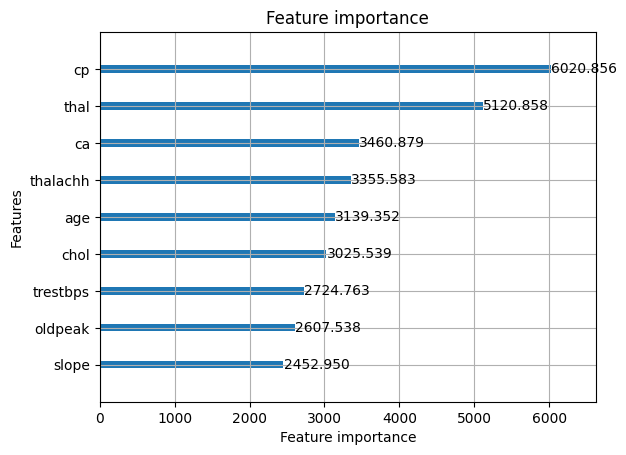

In [13]:
y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int) 

accuracy = accuracy_score(test[target], y_pred)
print(f'Accuracy на тесте: {accuracy:.4f}')
print(classification_report(test[target], y_pred))

lgb.plot_importance(model, max_num_features=50, importance_type='gain')

y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)

roc_auc = roc_auc_score(test[target], y_pred_prob)
print(f'ROC-AUC Score на тесте: {roc_auc:.4f}')

In [14]:
roc_auc_train = roc_auc_score(train[target], model.predict(train.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

1.0


In [15]:
roc_auc_train = roc_auc_score(val[target], model.predict(val.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

0.9921182266009851
